# 11.4.1 베이즈 정리
 - $p(H|D) : 특정한 자료 D가 나왔음을 확인한 상황에서 H가 맞을 확률$
 - $p(H|D) = {p(H)p(D|H) \over p(D)}$

ex) 상자 B1, B2가 존재
 - 상자 B1 : 검은공 20개, 붉은공 70개
 - 상자 B2 : 검은공 40개, 붉은공 50개
 - 가설 H1 : 공은 상자 B1에서 나왔다.
 - 가설 H2 : 공은 상자 B2에서 나왔다.


1. 공을 꺼내기 전
 - 두 가설의 확률 : 0.5 동일
 
2. 꺼낸 공이 검은 공인 경우 H1의 확률
 - p(H1) = 0.5
 - p(D) = 0.5 * 0.2 + 0.5 * 0.4 = 0.3
 - p(D|H1) = 0.2
 - -> p(H1|D) = ${(0.5 * 0.2) \over 0.3} = {1 \over 3}$

# 11.4.2 PyMC3
 - PyMC3 : 베이즈 통계를 기술적으로 구현할 수 있는 고선능 라이브러리

In [1]:
# conda install anaconda pymc3

PyMC3 웹사이트 주기적으로 확인 필요 : https://github.com/pymc-devs/pymc3

In [2]:
import warnings
warnings.simplefilter('ignore')
import pymc3 as pm
import numpy as np
np.random.seed(1000)
import matplotlib.pyplot as plt
%matplotlib inline

# 11.4.3 기초 예제

In [3]:
x = np.linspace(0, 10, 500)
y = 4 + 2 * x + np.random.standard_normal(len(x)) * 2

In [4]:
reg = np.polyfit(x, y, 1) # 선형 회귀분석 (9장 참조)
reg

array([2.03384161, 3.77649234])

Text(0, 0.5, 'y')

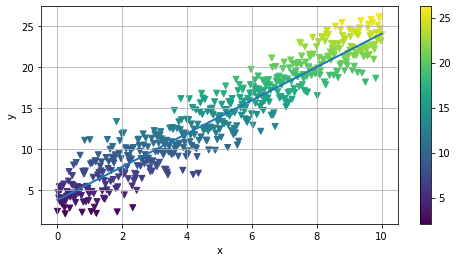

In [5]:
plt.figure(figsize = (8, 4))
plt.scatter(x, y, c = y, marker = 'v')
plt.plot(x, reg[1] + reg[0] * x, lw = 2.0)
plt.colorbar()
plt.grid(True)
plt.xlabel('x')
plt.ylabel('y')

In [6]:
reg # 고정된 회귀선의 인수 값

array([2.03384161, 3.77649234])

원래의 인수 값 2, 4 완벽하게 복원 X

-> 베이즈 회귀분석 -> 모수가 특정한 분포를 가진다고 가정

EX) 회귀선 : $y(x) = \alpha  + \beta * x$
 - $\alpha$ : 평균이 0 이고, 표준편차가 20인 정규분포
 - $\beta$ : 평균이 0 이고, 표준편차가 20인 정규분포

우도의 경우 : 평균이 y(x) 이고, 정규 분포이며 표준편차는 0과 10 사이의 상수 분포를 가지는 확률변수라고 가정

베이즈 회귀분석의 중요한 방법 중 하나 : 마코프 체인 몬테카를로 방법(MCMC)
 - http://en.wikipedia.org/wiki/Markow_chain_Monte_Carlo

몬테카를로 샘플링을 위한 세가지 함수

1. find_MAP : 사후 확률을 최대화하는 국지점을 계산 -> 샘플링 알고리즘의 시작점 찾기

2. NUTS : efficient No-U-Turn Sampler with  dual averaging의 약자, 주어진 사전 확률에 따른 MCMC 샘플링 알고리즘 구현

3. sample : find_MAP에서 주어진 초깃값과 NUTS 알고리즘에서 구한 최적 구간 크기를 사용 -> 샘플 생성

In [7]:
with pm.Model() as model:
        # PyMC3의 모형은 with문 안에서 사용됨
    
    # 사전 확률 정의
    alpha = pm.Normal('alpha', mu = 0, sd = 20)
    beta = pm.Normal('beta', mu = 0, sd = 20)
    sigma = pm.Uniform('sigma', lower = 0, upper = 10)
    
    # 선형 회귀선 정의
    y_est = alpha + beta * x
    
    # 우도 정의
    likelihood = pm.Normal('y', mu = y_est, sd = sigma, observed = y)
    
    # 추정 과정
    start = pm.find_MAP()
        # 최적화를 사용하여 시작값 추정
    
    step = pm.NUTS()
        # MCMC 샘플링 알고리즘 인스턴스 생성
    
    trace = pm.sample(100, step, start = start, progressbar = False)
        # NUTS 샘플링을 사용한 100개의 사후 샘플 생성

logp = -1,068.5, ||grad|| = 60.625: 100%|████| 28/28 [00:00<00:00, 2806.90it/s]
Only 100 samples in chain.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]
The acceptance probability does not match the target. It is 0.8871599362079703, but should be close to 0.8. Try to increase the number of tuning steps.


In [8]:
trace[0]

{'alpha': 3.7352301620074684,
 'beta': 2.0326623910434938,
 'sigma_interval__': -1.3888000621205414,
 'sigma': 1.9959938919277014}

<Figure size 576x576 with 0 Axes>

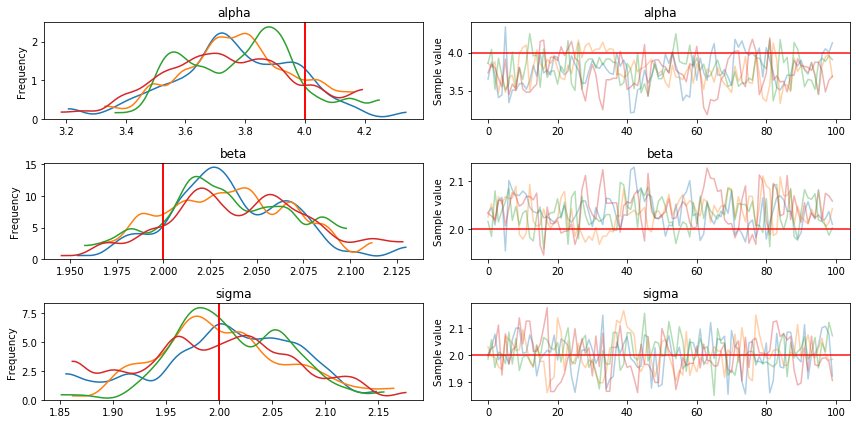

<Figure size 576x576 with 0 Axes>

In [9]:
fig = pm.traceplot(trace, lines = {'alpha' : 4, 'beta' : 2, 'sigma' : 2})
plt.figure(figsize = (8, 8))

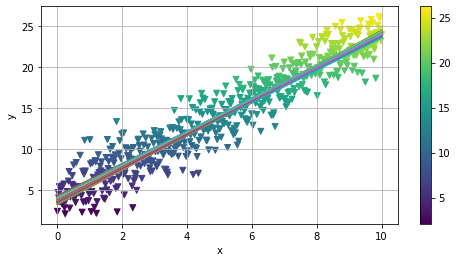

In [10]:
plt.figure(figsize = (8, 4))
plt.scatter(x, y, c = y, marker = 'v')
plt.colorbar()
plt.grid(True)
plt.xlabel('x')
plt.ylabel('y')
for i in range(len(trace)):
    plt.plot(x, trace['alpha'][i] + trace['beta'][i] * x)

# 11.4.4 현실 자료 적용

In [11]:
import warnings
warnings.simplefilter('ignore')
import pytz
import datetime as dt
import pandas as pd
from pandas_datareader import data as web
import yfinance as yf
yf.pdr_override()

In [12]:
# import zipline # 3.5버전으로 실행해야함 but, load_from_yahoo 지원 X -> zipline 사용 X

In [13]:
symbols = ['GLD', 'GDX']

In [14]:
data = pd.DataFrame()
for sym in symbols:
    data[sym] = web.get_data_yahoo(sym, data_source = 'yahoo', start = '2006-05-20', end = '2014-03-15')['Adj Close']
data = data.dropna()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1967 entries, 2006-05-22 to 2014-03-14
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   GLD     1967 non-null   float64
 1   GDX     1967 non-null   float64
dtypes: float64(2)
memory usage: 46.1 KB


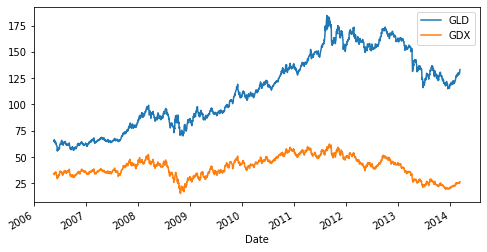

In [16]:
data.plot(figsize = (8, 4))

In [17]:
data.iloc[-1] / data.iloc[0] -1

GLD    1.038285
GDX   -0.215999
dtype: float64

In [18]:
data.corr()

,GLD,GDX
GLD,1.00000,0.46696
GDX,0.46696,1.00000


In [19]:
data.index

DatetimeIndex(['2006-05-22', '2006-05-23', '2006-05-24', '2006-05-25',
               '2006-05-26', '2006-05-30', '2006-05-31', '2006-06-01',
               '2006-06-02', '2006-06-05',
               ...
               '2014-03-03', '2014-03-04', '2014-03-05', '2014-03-06',
               '2014-03-07', '2014-03-10', '2014-03-11', '2014-03-12',
               '2014-03-13', '2014-03-14'],
              dtype='datetime64[ns]', name='Date', length=1967, freq=None)

In [20]:
import matplotlib as mpl

In [21]:
mpl_dates = mpl.dates.date2num(data.index)

In [22]:
mpl_dates

array([732453., 732454., 732455., ..., 735304., 735305., 735306.])

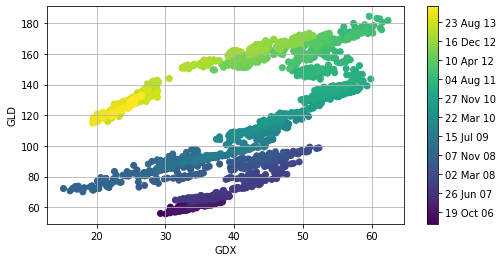

In [23]:
plt.figure(figsize = (8, 4))
plt.scatter(data['GDX'], data['GLD'], c = mpl_dates, marker = 'o')
plt.grid(True)
plt.xlabel('GDX')
plt.ylabel('GLD')
plt.colorbar(ticks = mpl.dates.DayLocator(interval = 250),
            format = mpl.dates.DateFormatter('%d %b %y'))

GLD와 GDX 가격의 스캐터 플롯

In [ ]:
with pm.Model() as model:
    alpha = pm.Normal('alpha', mu = 0, sd = 20)
    beta = pm.Normal('beta', mu = 0, sd = 20)
    sigma = pm.Uniform('sigma', lower = 0, upper = 50)
    y_est = alpha + beta * data['GDX'].values
    likelihood = pm.Normal('GLD', mu = y_est, sd = sigma,
                          observed = data['GLD'].values)
    start = pm.find_MAP()
    step = pm.NUTS()
    trace = pm.sample(100, step, start = start, progressbar = False)

In [ ]:
fig = pm.traceplot(trace)
plt.figure(figsize = (8, 8))

In [ ]:
plt.figure(figsize = (8, 4))
plt.scatter(data['GDX'], data['GLD'], c = mpl_dates, marker = 'o')
plt.grid(True)
plt.xlabel('GDX')
plt.ylabel('GLD')
for i in range(len(trace)):
    plt.plot(data['GDX'], trace['alpha'][i] + trace['beta'][i] * data['GDX'])
plt.colorbar(ticks = mpl.dates.DayLocator(interval = 250),
                format = mpl.dates.DateFormatter('%d %b %y'))

문제점 : 시간에 따른 변화를 고려 X, 즉, 최근 자료를 과거의 자료와 동일하게 다룸

시간이 지나면 새로운 자료가 추가 -> 회귀 및 추정 결과 개선

-> 회귀 모수가 고정 확률 분포 X, 시간에 따라 변화하는 일종의 랜덤 워크 형태

In [ ]:
from pymc3.distributions.continuous import Exponential
model_randomwalk = pm.Model()
with model_randomwalk:
    sigma_alpha = Exponential('sigma_alpha', 1. / .02, testval = .1 )
    sigma_beta = Exponential('sigma_beta', 1. / .02, testval = .1)

alpha & beta도 랜덤 워크 가정 적용 / 전체 계산 효율성 위해 50개씩 같은 계수 공유하도록 한다.

In [ ]:
from pymc3.distributions.timeseries import GaussianRandomWalk
subsample_alpha = 195
subsample_beta = 195

with model_randomwalk:
    alpha = GaussianRandomWalk('alpha', sigma_alpha ** -2,
                              shape = int(len(data) / subsample_alpha))
    beta = GaussianRandomWalk('beta', sigma_beta ** -2,
                             shape = int(len(data) / subsample_beta))
    
    # 계수 자료의 길이를 가격 자료와 같게 만든다
    alpha_r = np.repeat(alpha, subsample_alpha)
    beta_r = np.repeat(beta, subsample_beta)

In [ ]:
len(data.dropna().GDX.values)

50개씩 나누어 적용하기 위해 1950개 자료만 회귀분석에 사용

In [ ]:
with model_randomwalk:
    # 회귀식 정의
    regression = alpha_r + beta_r * data.GDX.values[:1950]
    
    # 가격이 정규분포라고 가정
    # 평균은 regression에서 구한다.
    sd = pm.Uniform('sd', 0, 20)
    likelihood = pm.Normal('GLD',
                          mu = regression,
                          sd = sd,
                          observed = data.GLD.values[:1950])

In [ ]:
import scipy.optimize as sco

In [ ]:
with model_randomwalk:
    # 최적화를 사용하여 랜덤 위크의 모수 분포 초깃값 추정
    start = pm.find_MAP(vars = [alpha, beta], fmin = sco.fmin_l_bfgs_b)
    
    # 샘플링
    step = pm.NUTS(scaling = start)
    trace_rw = pm.sample(100, step, start = start, progressbar = False)

In [ ]:
np.shape(trace_rw['alpha'])